In [1]:
%matplotlib inline

In [2]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

/home/a/a270046/eccodes-python/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


### load Cycle 3 IFS-FESOM output

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [4]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'IFS_4.4-FESOM_5-cycle3'?
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [5]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask()

In [6]:
data = ds

Get the grid

In [7]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)

List the variables included

In [8]:
data

<xarray.Dataset>
Dimensions:  (time: 43394, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [9]:
# more information on a variable, whole list is in the cell above under "Data variables"
data.variables['ci']

<xarray.Variable (time: 43394, value: 26306560)>
dask.array<concatenate, shape=(43394, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Attributes: (12/16)
    paramId:                    31
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     sea_ice_area_fraction
    cfVarName:                  siconc
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [10]:
# select a date
data_sample = data.ci.sel(time='2020-02-13-08:00:00')

Interpolate to...

In [11]:
lon = np.linspace(130, 160, 15*20)
lat = np.linspace(65, 80, 15*20)
lon2, lat2 = np.meshgrid(lon, lat)

points_ifs = np.vstack((lon_nonan, lat_nonan)).T

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

Plot

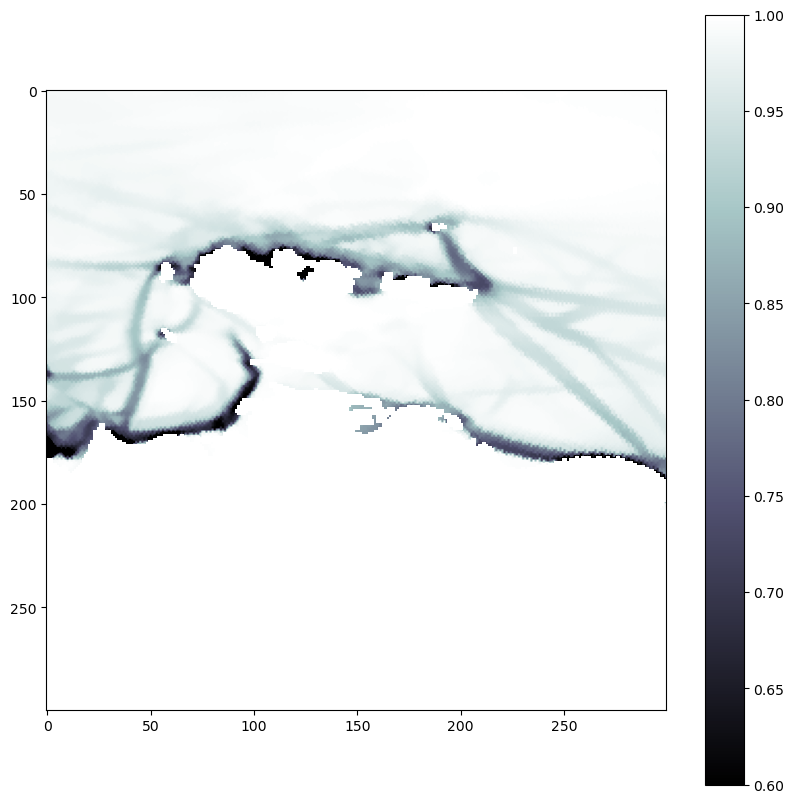

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(interpolated_nn),cmap=cm.bone, vmin=0.6, vmax=1.0)
plt.colorbar()

In [13]:
data_sample2 = data['2t'].sel(time='2020-02-13-08:00:00') - 273.15

In [14]:
nn_interpolation2 = NearestNDInterpolator(points_ifs, data_sample2.values[nonan])
interpolated_nn2 = nn_interpolation2((lon2, lat2))

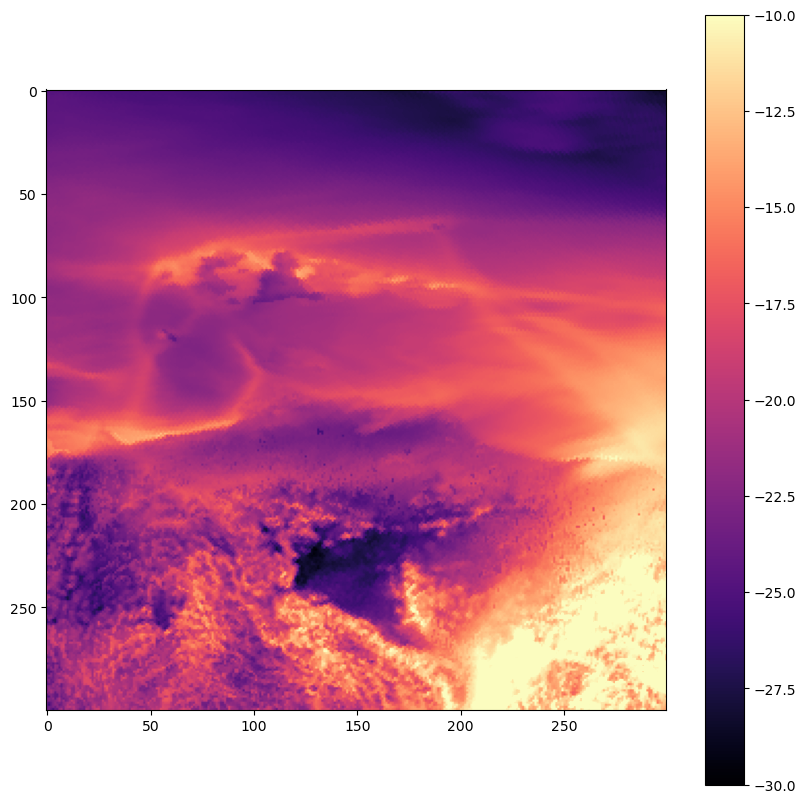

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(interpolated_nn2),cmap=cm.magma, vmin=-30., vmax=-10.)
plt.colorbar()

In [16]:
data_lsm = data.lsm[1,:]
lsm_interpolation = NearestNDInterpolator(points_ifs, data_lsm.values[nonan])
interpolated_lsm = lsm_interpolation((lon2, lat2))

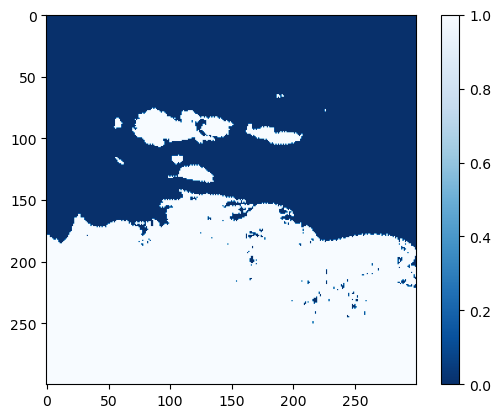

In [17]:
plt.imshow(np.flipud(interpolated_lsm)>0.5,cmap=cm.Blues_r)
plt.colorbar()

In [18]:
mask=np.flipud(interpolated_lsm)<=0.5

In [31]:
import pickle
dump = {'ice': interpolated_nn, '2mT': interpolated_nn2, 'mask': mask}

with open('Fig15.pickle', 'wb') as f:
    pickle.dump(dump, f, protocol=pickle.HIGHEST_PROTOCOL)

### load Cycle 3 IFS-FESOM output from pickle file

In [ ]:
with open('../data/Fig15.pickle', 'rb') as f:
    Fig15data = pickle.load(f)

In [34]:
interpolated_nn = Fig15data['ice']
interpolated_nn2 = Fig15data['2mT']
mask = Fig15data['mask']

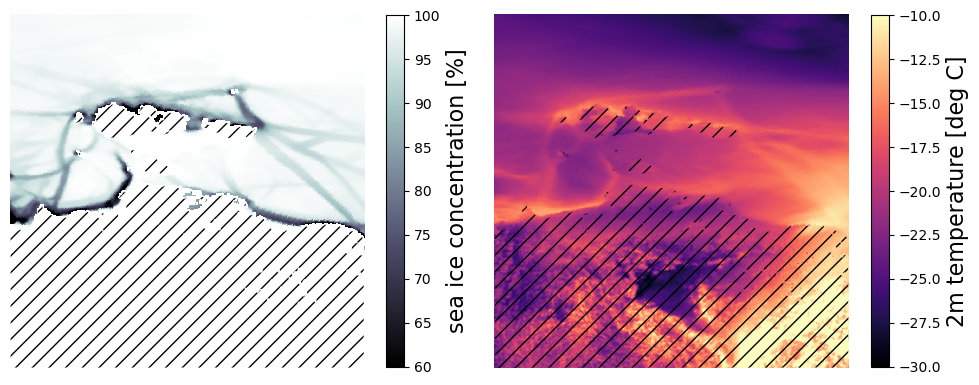

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,4.2))

im=ax1.imshow(np.flipud(interpolated_nn)*100.,cmap=cm.bone, vmin=60, vmax=100)
cbar=plt.colorbar(mappable=im, ax=ax1, shrink=0.9)
cbar.set_label('sea ice concentration [%]', fontsize=16)
ax1.contourf(mask, mask, levels=[-1,0], hatches=['//', ''], alpha=0)
ax1.axis('off')

im=ax2.imshow(np.flipud(interpolated_nn2),cmap=cm.magma, vmin=-30., vmax=-10.)
cbar=plt.colorbar(mappable=im, ax=ax2, shrink=0.9)
cbar.set_label('2m temperature [deg C]', fontsize=16)
ax2.contourf(mask, mask, levels=[-1,0], hatches=['//', ''], alpha=0)
ax2.axis('off')

plt.tight_layout()
plt.show()

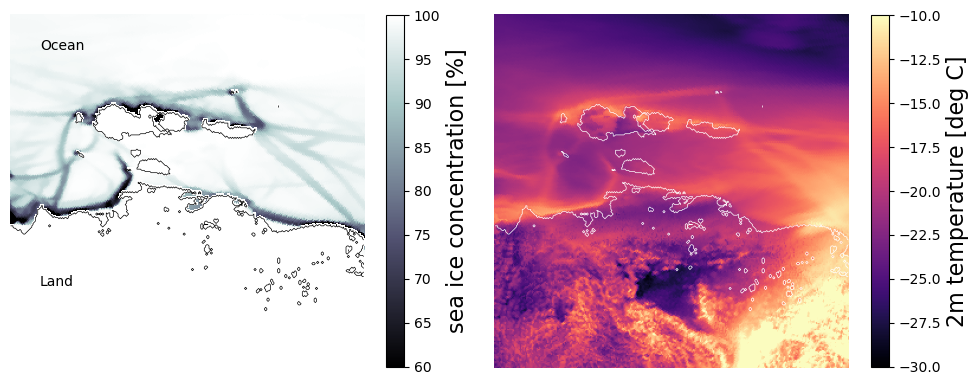

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,4.2))

im=ax1.imshow(np.flipud(interpolated_nn)*100.,cmap=cm.bone, vmin=60, vmax=100)
cbar=plt.colorbar(mappable=im, ax=ax1, shrink=0.9)
cbar.set_label('sea ice concentration [%]', fontsize=16)
ax1.contour(mask, mask, levels=[-1,0,1],colors=['k','k','k'],linewidths=[0.5,0.5,0.5])
#ax1.coastlines(color='k')
ax1.axis('off')
ax1.text(25,230,'Land')
ax1.text(25,30,'Ocean')


im=ax2.imshow(np.flipud(interpolated_nn2),cmap=cm.magma, vmin=-30., vmax=-10.)
cbar=plt.colorbar(mappable=im, ax=ax2, shrink=0.9)
cbar.set_label('2m temperature [deg C]', fontsize=16)
ax2.contour(mask, mask, levels=[-1,0,1],colors=['w','w','w'],linewidths=[0.5,0.5,0.5])
#ax2.coastlines(color='k')
ax2.axis('off')


plt.tight_layout()
#plt.show()
plt.savefig('Figure15.pdf')